# Practical Statistics for Data Scientists (R)

> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required R packages.

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(lubridate)
library(ellipse)
library(mclust)
library(cluster)
library(ca)

Warning message:
“package ‘dplyr’ was built under R version 4.1.2”



Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Warning message:
“package ‘tidyr’ was built under R version 4.1.2”



Attaching package: ‘lubridate’




The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union





Attaching package: ‘ellipse’




The following object is masked from ‘package:graphics’:

    pairs




Package 'mclust' version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



Warning message:
“package ‘cluster’ was built under R version 4.1.2”


Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [2]:
PSDS_PATH <- file.path(dirname(dirname(getwd())))

sp500_px <- read.csv(file.path(PSDS_PATH, 'data', 'sp500_data.csv.gz'), row.names=1)
sp500_sym <- read.csv(file.path(PSDS_PATH, 'data', 'sp500_sectors.csv'), stringsAsFactors = FALSE)
loan_data <- read.csv(file.path(PSDS_PATH, 'data', 'loan_data.csv.gz'))
loan_data$outcome <- ordered(loan_data$outcome, levels=c('paid off', 'default'))
housetasks <- read.csv(file.path(PSDS_PATH, 'data', 'housetasks.csv'), row.names=1)

# Principal Components Analysis
## A simple example

In [3]:
oil_px <- sp500_px[, c('CVX', 'XOM')]
pca <- princomp(oil_px)
pca$loadings


Loadings:
    Comp.1 Comp.2
CVX  0.747  0.665
XOM  0.665 -0.747

               Comp.1 Comp.2
SS loadings       1.0    1.0
Proportion Var    0.5    0.5
Cumulative Var    0.5    1.0

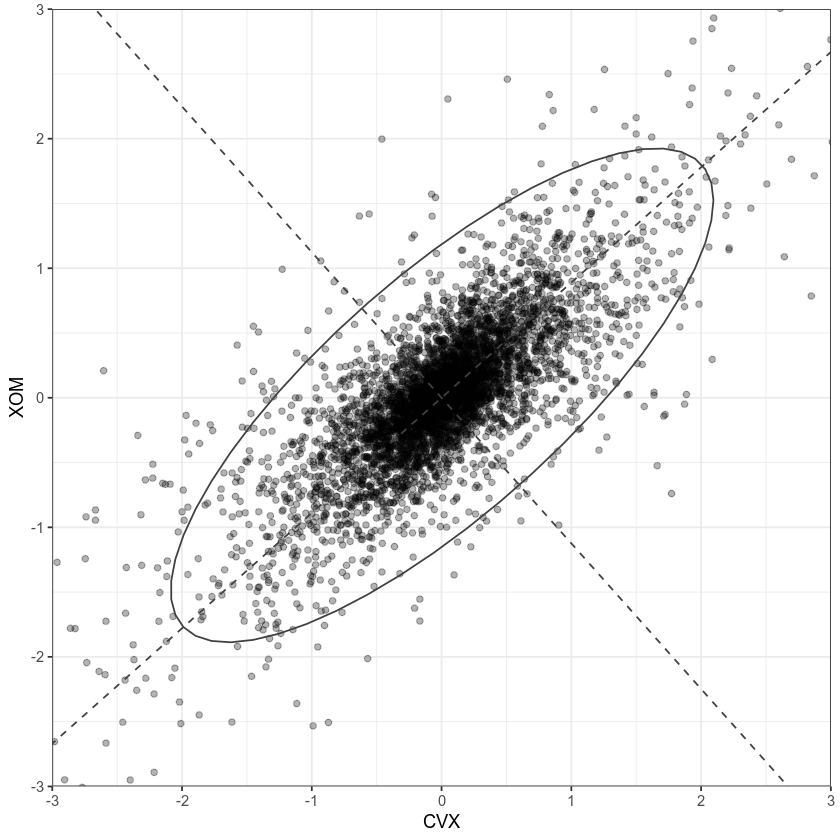

In [4]:
loadings <- pca$loadings
graph <- ggplot(data=oil_px, aes(x=CVX, y=XOM)) +
  geom_point(alpha=.3) +
  scale_shape_manual(values=c(46)) +
  stat_ellipse(type='norm', level=.99, color='grey25') +
  geom_abline(intercept = 0, slope = loadings[2,1]/loadings[1,1], color='grey25', linetype=2) +
  geom_abline(intercept = 0, slope = loadings[2,2]/loadings[1,2],  color='grey25', linetype=2) +
  scale_x_continuous(expand=c(0,0)) + 
  scale_y_continuous(expand=c(0,0)) +
  coord_cartesian(xlim=c(-3, 3), ylim=c(-3, 3)) +
  theme_bw()
graph

## Interpreting principal components

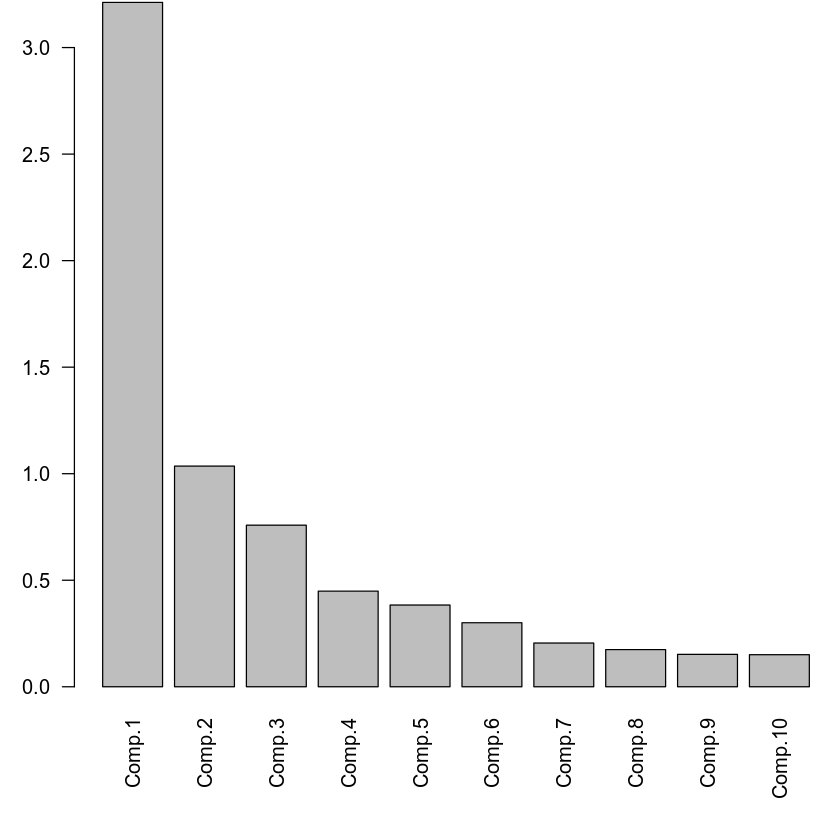

In [5]:
syms <- c( 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
           'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST')
top_sp <- sp500_px[row.names(sp500_px)>='2011-01-01', syms]
sp_pca <- princomp(top_sp)
par(mar=c(6,3,0,0)+.1, las=2)
screeplot(sp_pca, main='')

In [6]:
loadings <- sp_pca$loadings[,1:5]
loadings <- as.data.frame(loadings)
loadings$Symbol <- row.names(loadings)
loadings <- gather(loadings, 'Component', 'Weight', -Symbol)

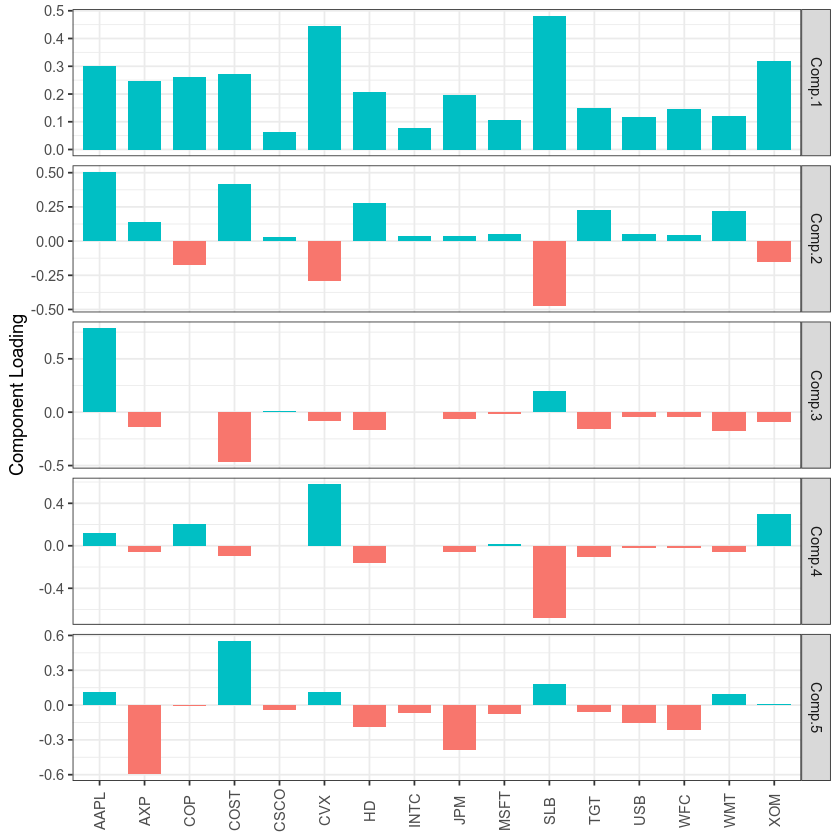

In [7]:
loadings$Color = loadings$Weight > 0
graph <- ggplot(loadings, aes(x=Symbol, y=Weight, fill=Color)) +
  geom_bar(stat='identity', position='identity', width=.75) + 
  facet_grid(Component ~ ., scales='free_y') +
  guides(fill='none') +
  ylab('Component Loading') +
  theme_bw() +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_text(angle=90, vjust=0.5))
graph

## Correspondence analysis

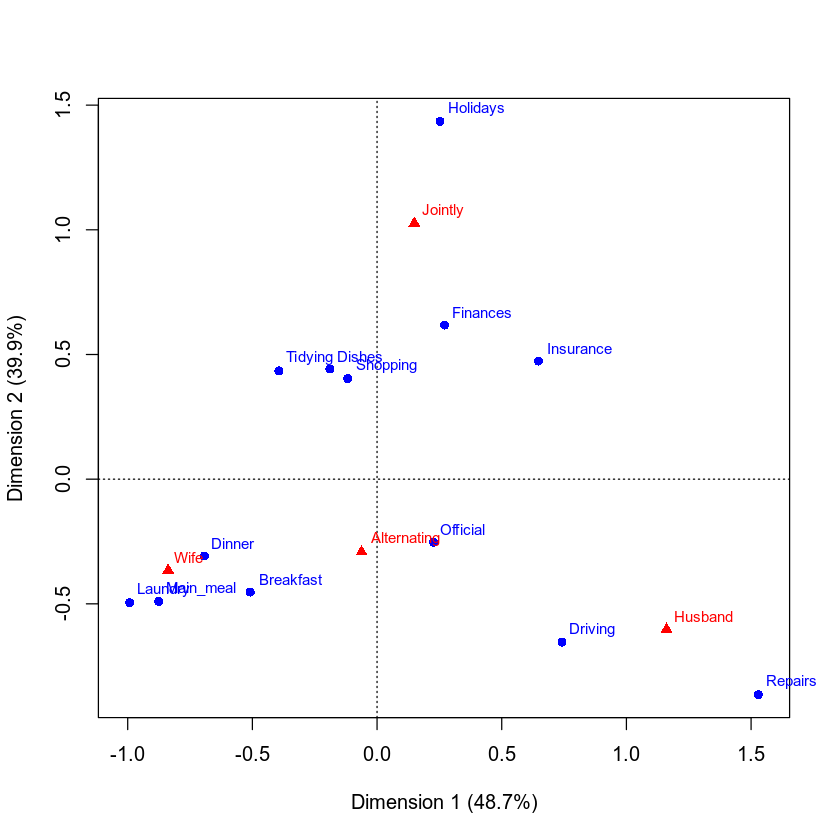

In [8]:
ca_analysis <- ca(housetasks)
plot(ca_analysis)

In [9]:
if (!require(ggrepel)) {
    install.packages('ggrepel')
    library(ggrepel)
}

Loading required package: ggrepel



In [10]:
ca_analysis$sv ** 2
summary(ca_analysis)

[1] 0.5428893 0.4450028 0.1270484


Principal inertias (eigenvalues):

 dim    value      %   cum%   scree plot               
 1      0.542889  48.7  48.7  ************             
 2      0.445003  39.9  88.6  **********               
 3      0.127048  11.4 100.0  ***                      
        -------- -----                                 
 Total: 1.114940 100.0                                 


Rows:
     name   mass  qlt  inr    k=1 cor ctr    k=2 cor ctr  
1  | Lndr |  101  925  120 | -992 740 183 | -495 185  56 |
2  | Mn_m |   88  974   81 | -876 742 124 | -490 232  47 |
3  | Dnnr |   62  930   34 | -693 777  55 | -308 154  13 |
4  | Brkf |   80  905   37 | -509 505  38 | -453 400  37 |
5  | Tdyn |   70  975   22 | -394 440  20 |  434 535  30 |
6  | Dshs |   65  764   18 | -189 118   4 |  442 646  28 |
7  | Shpp |   69  811   13 | -118  64   2 |  403 748  25 |
8  | Offc |   55  119   48 |  227  53   5 | -254  66   8 |
9  | Drvn |   80  767   91 |  742 432  81 | -653 335  76 |
10 | Fnnc |   65  997   27 |  

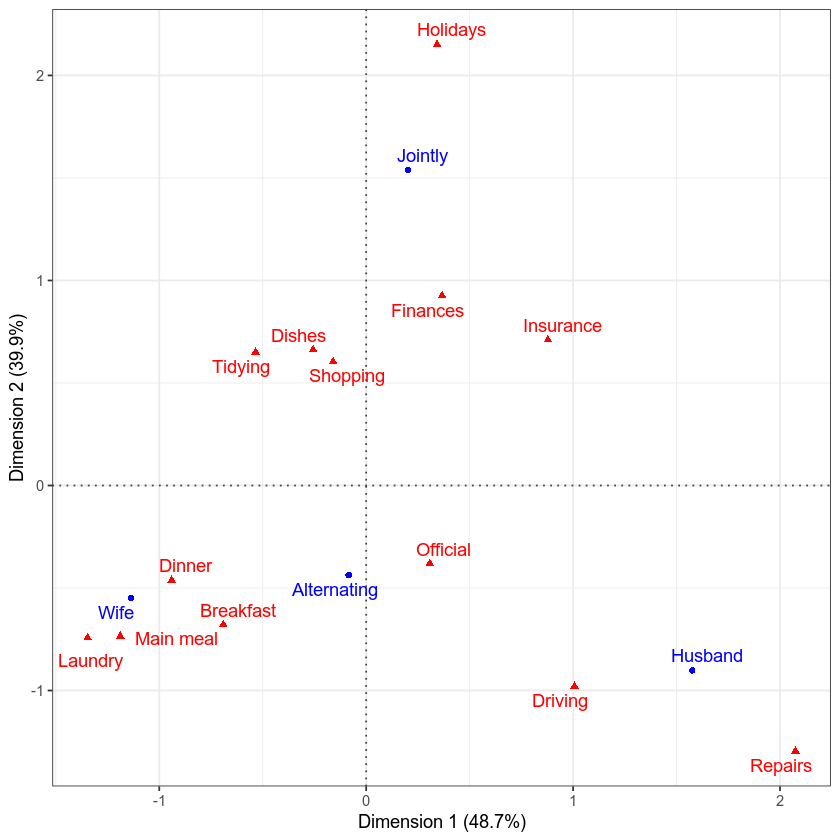

In [11]:
contrib = ca_analysis$sv ** 2
contrib = contrib / sum(contrib)
colcoord = as.data.frame(ca_analysis$colcoord)
rowcoord = as.data.frame(ca_analysis$rowcoord)
coords = rbind(
    cbind(rowcoord, type='rowcoord'),
    cbind(colcoord, type='columns')
)
row.names(coords) <- gsub('_', ' ', row.names(coords))

graph <- ggplot(coords, aes(x=Dim1, y=Dim2, color=type, label=rownames(coords), shape=type)) +
    geom_hline(yintercept=0, linetype='dotted', color='#444444') + 
    geom_vline(xintercept = 0, linetype='dotted', color='#444444') +
    geom_point() +
    geom_text_repel() + 
    xlab(sprintf('Dimension 1 (%.1f%%)', 100 * contrib[1])) +
    ylab(sprintf('Dimension 2 (%.1f%%)', 100 * contrib[2])) +
    scale_color_manual(values = c('blue', 'red')) +
    theme_bw() +
    theme(legend.position = "none") 
graph

# K-Means Clustering
## A Simple Example

In [12]:
set.seed(1010103)
df <- sp500_px[row.names(sp500_px)>='2011-01-01', c('XOM', 'CVX')]
km <- kmeans(df, centers=4, nstart=1)

df$cluster <- factor(km$cluster)
head(df)

,XOM,CVX,cluster
,<dbl>,<dbl>,<fct>
2011-01-03,0.73680496,0.2406809,1
2011-01-04,0.16866845,-0.5845157,4
2011-01-05,0.02663055,0.4469854,1
2011-01-06,0.24855834,-0.9197513,4
2011-01-07,0.33732892,0.1805111,1
2011-01-10,0.00000000,-0.4641675,4


In [13]:
centers <- data.frame(cluster=factor(1:4), km$centers)
centers

,cluster,XOM,CVX
,<fct>,<dbl>,<dbl>
1,1,0.2315403,0.3169645
2,2,0.9270317,1.3464117
3,3,-1.1439800,-1.7502975
4,4,-0.3287416,-0.5734695


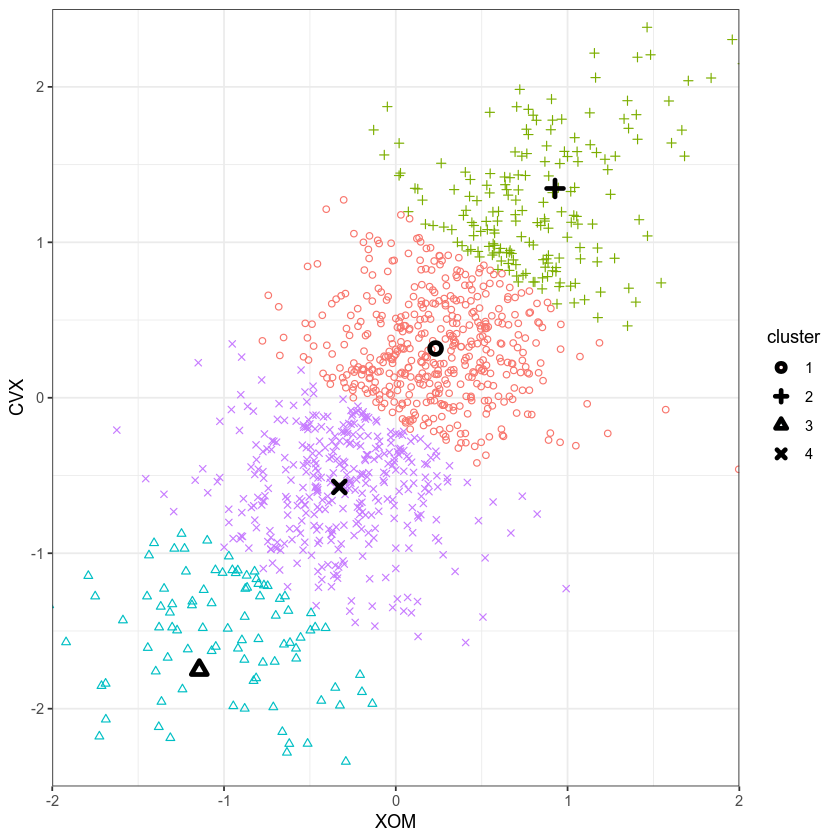

In [14]:
graph <- ggplot(data=df, aes(x=XOM, y=CVX, color=cluster, shape=cluster)) +
  geom_point() +
  scale_shape_manual(values = c(1, 3, 2, 4),
                     guide = guide_legend(override.aes=aes(size=1))) + 
  geom_point(data=centers,  aes(x=XOM, y=CVX), size=2, stroke=2, color='black')  +
  theme_bw() +
  scale_x_continuous(expand=c(0,0)) + 
  scale_y_continuous(expand=c(0,0)) +
  coord_cartesian(xlim=c(-2, 2), ylim=c(-2.5, 2.5))

graph

## K-Means Algorithm
The _scikit-learn_ algorithm is repeated 10 times by default (`n_init`), `max_iter` is used to control the number of iterations. 

In [15]:
syms <- c( 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
           'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST')
df <- sp500_px[row.names(sp500_px) >= '2011-01-01', syms]

set.seed(10010)
km <- kmeans(df, centers=5, nstart=10)

## Interpreting the Clusters

In [16]:
km$size

[1] 288 266 285 106 186

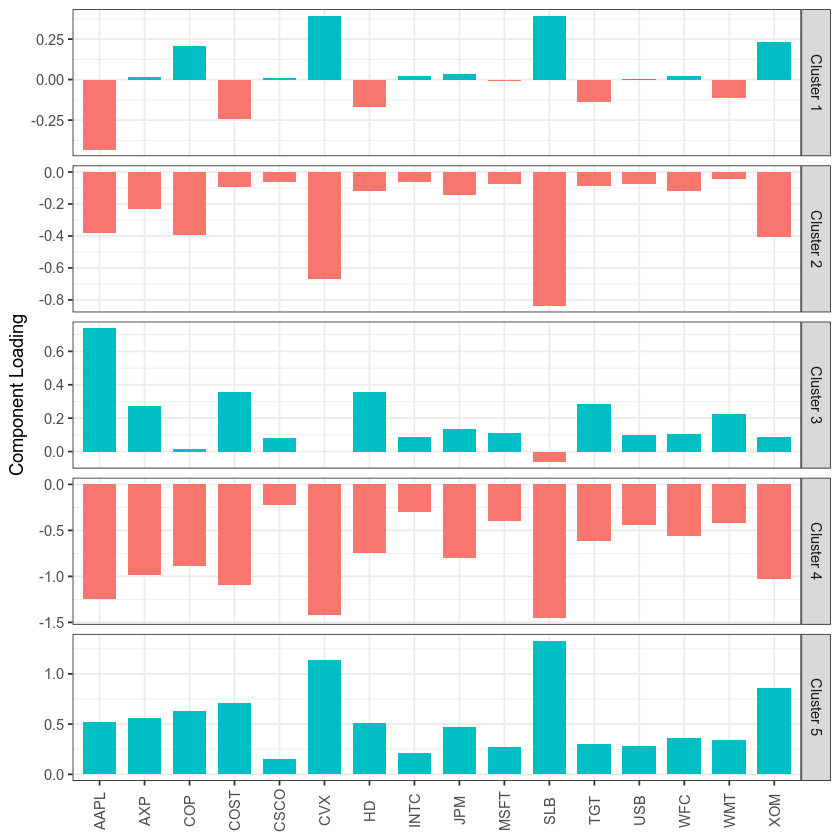

In [17]:
centers <- as.data.frame(t(km$centers))
names(centers) <- paste('Cluster', 1:5)
centers$Symbol <- row.names(centers)
centers <- gather(centers, 'Cluster', 'Mean', -Symbol)

centers$Color = centers$Mean > 0
graph <- ggplot(centers, aes(x=Symbol, y=Mean, fill=Color)) +
  geom_bar(stat='identity', position='identity', width=.75) + 
  facet_grid(Cluster ~ ., scales='free_y') +
  guides(fill='none')  +
  ylab('Component Loading') +
  theme_bw() +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_text(angle=90, vjust=0.5))
graph

## Selecting the Number of Clusters

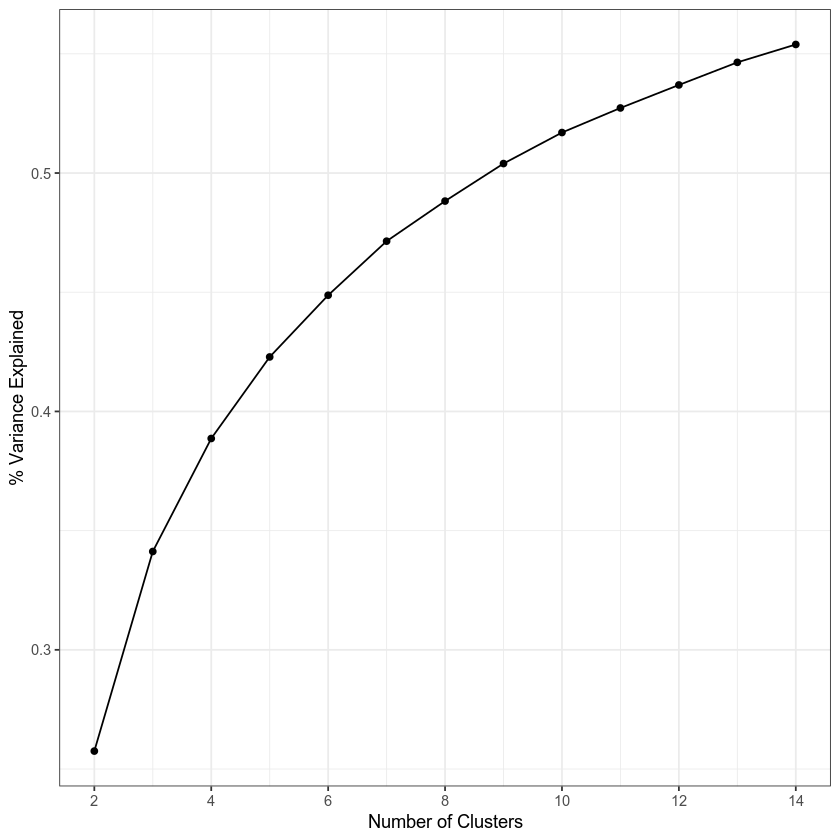

In [18]:
pct_var <- data.frame(pct_var = 0,
                      num_clusters=2:14)
totalss <- kmeans(df, centers=14, nstart=50, iter.max=100)$totss
for (i in 2:14) {
  kmCluster <- kmeans(df, centers=i, nstart=50, iter.max = 100)
  pct_var[i-1, 'pct_var'] <- kmCluster$betweenss / totalss
}

graph <- ggplot(pct_var, aes(x=num_clusters, y=pct_var)) +
  geom_line() +
  geom_point() +
  labs(y='% Variance Explained', x='Number of Clusters') +
  scale_x_continuous(breaks=seq(2, 14, by=2))   +
  theme_bw()
graph

# Hierarchical Clustering
## A Simple Example

In [19]:
syms1 <- c('GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 
           'XOM', 'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP',
           'WMT', 'TGT', 'HD', 'COST')

df <- sp500_px[row.names(sp500_px) >= '2011-01-01', syms1]
d <- dist(t(df))
hcl <- hclust(d)

## The Dendrogram

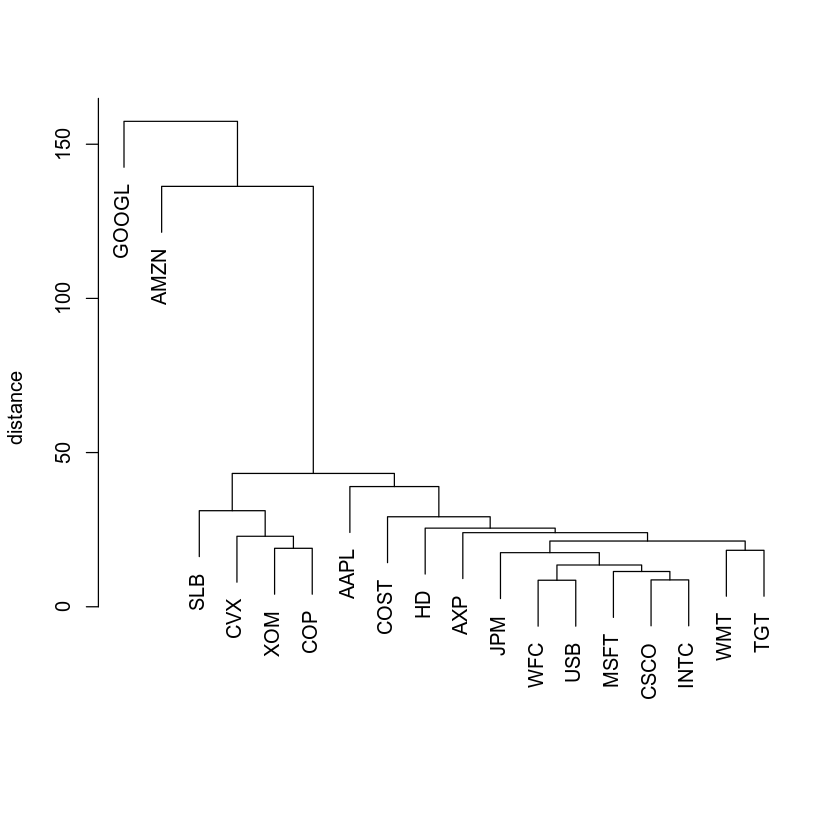

In [20]:
plot(hcl, ylab='distance', xlab='', sub='', main='')

In [21]:
cutree(hcl, k=4)

GOOGL  AMZN  AAPL  MSFT  CSCO  INTC   CVX   XOM   SLB   COP   JPM   WFC   USB 
    1     2     3     3     3     3     4     4     4     4     3     3     3 
  AXP   WMT   TGT    HD  COST 
    3     3     3     3     3

## Measures of Dissimilarity

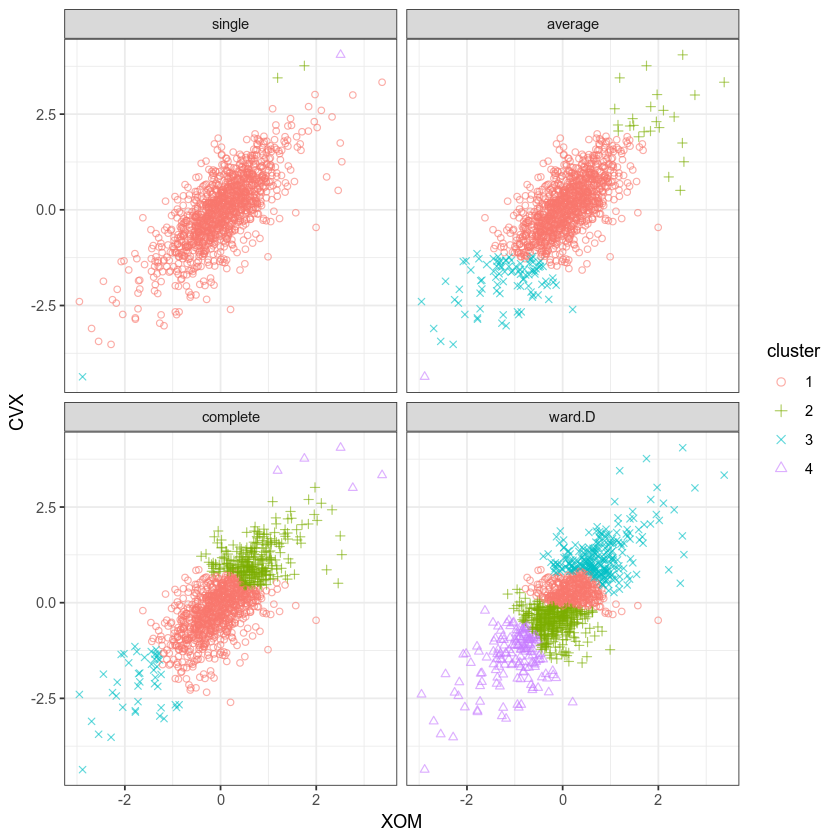

In [22]:
cluster_fun <- function(df, method)
{
  d <- dist(df)
  hcl <- hclust(d, method=method)
  tree <- cutree(hcl, k=4)
  df$cluster <- factor(tree)
  df$method <- method
  return(df)
}

df0 <- sp500_px[row.names(sp500_px) >= '2011-01-01', c('XOM', 'CVX')]
df <- rbind(cluster_fun(df0, method='single'),
            cluster_fun(df0, method='average'),
            cluster_fun(df0, method='complete'),
            cluster_fun(df0, method='ward.D'))
df$method <- ordered(df$method, c('single', 'average', 'complete', 'ward.D'))

graph <- ggplot(data=df, aes(x=XOM, y=CVX, color=cluster, shape=cluster)) +
  geom_point(alpha=0.6) +
  scale_shape_manual(values=c(1, 3, 4, 2),
                     guide=guide_legend(override.aes=aes(size=2))) +
  facet_wrap( ~ method) +
  theme_bw()
graph

# Model based clustering
## Multivariate Normal Distribution
> Define a colormap that corresponds to the probability levels

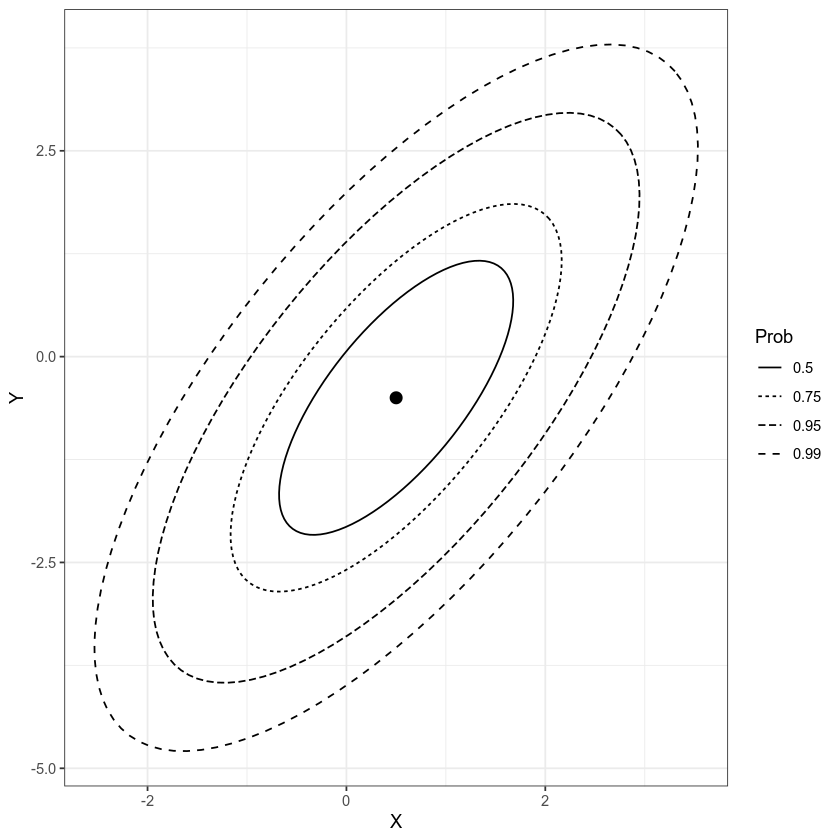

In [23]:
mu <- c(.5, -.5)
sigma <- matrix(c(1, 1, 1, 2), nrow=2)
prob <- c(.5, .75, .95, .99) ## or whatever you want
names(prob) <- prob ## to get id column in result
x <- NULL
for (p in prob){
  x <- rbind(x,  ellipse(x=sigma, centre=mu, level=p))
}
df <- data.frame(x, prob=factor(rep(prob, rep(100, length(prob)))))
names(df) <- c('X', 'Y', 'Prob')

## Figure 7-9: Multivariate normal ellipses
dfmu <- data.frame(X=mu[1], Y=mu[2])

graph <- ggplot(df, aes(X, Y)) + 
  geom_path(aes(linetype=Prob)) +
  geom_point(data=dfmu, aes(X, Y), size=3) +
  theme_bw()
graph

## Mixtures of Normals

In [24]:
df <- sp500_px[row.names(sp500_px)>='2011-01-01', c('XOM', 'CVX')]
mcl <- Mclust(df)
summary(mcl)

---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust VEE (ellipsoidal, equal shape and orientation) model with 2 components: 

 log-likelihood    n df       BIC       ICL
      -2255.125 1131  9 -4573.528 -5075.657

Clustering table:
  1   2 
168 963 

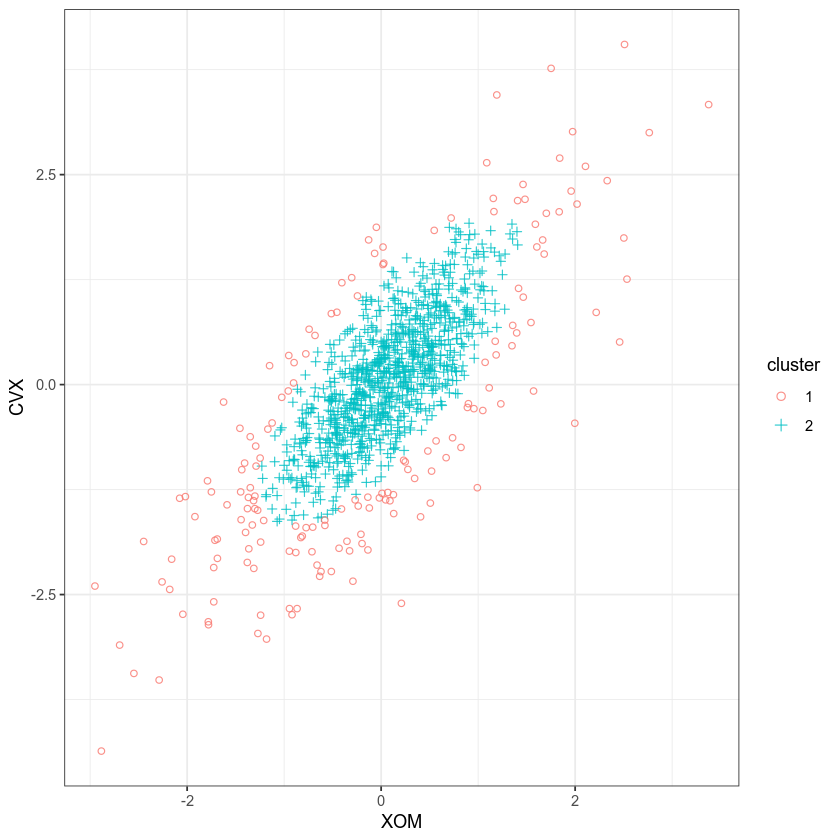

In [25]:
cluster <- factor(predict(mcl)$classification)
graph <- ggplot(data=df, aes(x=XOM, y=CVX, color=cluster, shape=cluster)) +
  geom_point(alpha=.8) +
  theme_bw() +
  scale_shape_manual(values = c(1, 3),
                     guide = guide_legend(override.aes=aes(size=2))) 
graph

In [26]:
summary(mcl, parameters=TRUE)$mean
summary(mcl, parameters=TRUE)$variance[,,1]
summary(mcl, parameters=TRUE)$variance[,,2]

XOM,-0.04362218,0.05792282
CVX,-0.21109525,0.07375447


,XOM,CVX
XOM,1.044671,1.065190
CVX,1.065190,1.912748


,XOM,CVX
XOM,0.2998935,0.3057838
CVX,0.3057838,0.5490920


## Selecting the number of clusters

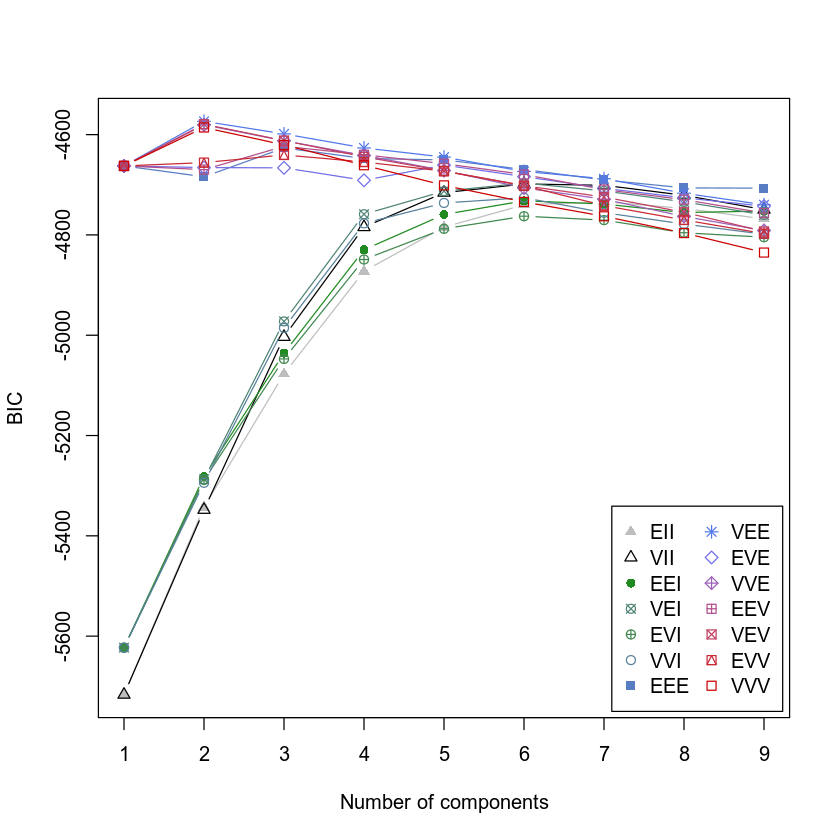

In [27]:
plot(mcl, what='BIC', ask=FALSE, cex=.75)

# Scaling and Categorical Variables
## Scaling the Variables

In [28]:
defaults <- loan_data[loan_data$outcome=='default',]
df <- defaults[, c('loan_amnt', 'annual_inc', 'revol_bal', 'open_acc', 'dti', 'revol_util')]
km <- kmeans(df, centers=4, nstart=10)
centers <- data.frame(size=km$size, km$centers) 
print(round(centers, digits=2))

   size loan_amnt annual_inc revol_bal open_acc   dti revol_util
1    52  22570.19  489783.40  85161.35    13.33  6.91      59.65
2 13819  10577.04   42380.98  10245.27     9.58 17.71      58.09
3  1221  21797.26  164503.32  38652.54    12.61 13.53      63.65
4  7579  18247.71   83069.61  19587.30    11.66 16.79      62.26


In [29]:
df0 <- scale(df)
km0 <- kmeans(df0, centers=4, nstart=10)
centers0 <- scale(km0$centers, center=FALSE, scale=1/attr(df0, 'scaled:scale'))
centers0 <- scale(centers0, center=-attr(df0, 'scaled:center'), scale=FALSE)
centers0 <- data.frame(size=km0$size, centers0) 
print(round(centers0, digits=2))

  size loan_amnt annual_inc revol_bal open_acc   dti revol_util
1 7352  10469.87   51123.20  11525.60     7.48 15.79      77.73
2 6299  13363.49   55586.54  16363.84    14.24 24.22      59.59
3 3713  25892.73  116197.49  32803.62    12.41 16.22      66.15
4 5307  10356.29   53539.85   6037.84     8.68 11.30      30.72


In [30]:
km <- kmeans(df, centers=4, nstart=10)
centers <- data.frame(size=km$size, km$centers) 
round(centers, digits=2)

,size,loan_amnt,annual_inc,revol_bal,open_acc,dti,revol_util
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,13902,10606.48,42500.30,10280.52,9.59,17.71,58.11
2,1192,21856.38,165473.54,38935.88,12.61,13.48,63.67
3,52,22570.19,489783.40,85161.35,13.33,6.91,59.65
4,7525,18282.25,83458.11,19653.82,11.66,16.77,62.27


## Dominant Variables

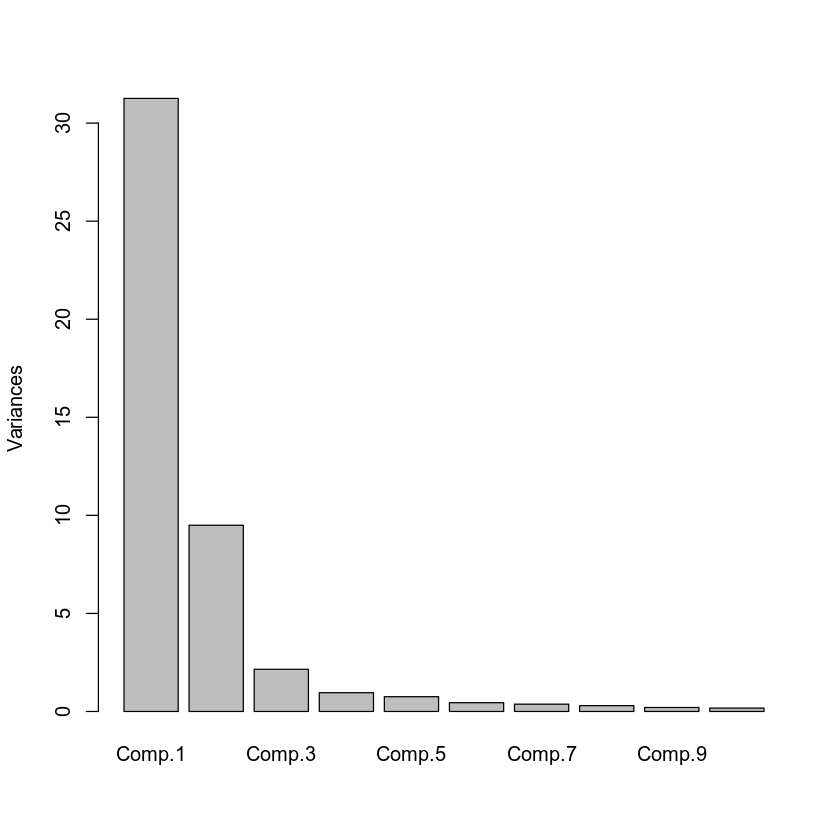

In [31]:
syms <- c('GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 
          'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST')
top_15 <- sp500_px[row.names(sp500_px)>='2011-01-01', syms]
sp_pca1 <- princomp(top_15)

screeplot(sp_pca1, main='')

In [32]:
round(sp_pca1$loadings[,1:2], 3)

,Comp.1,Comp.2
GOOGL,0.781,0.609
AMZN,0.593,-0.792
AAPL,0.078,0.004
MSFT,0.029,0.002
CSCO,0.017,-0.001
INTC,0.020,-0.001
CVX,0.068,-0.021
XOM,0.053,-0.005
SLB,0.079,-0.013
COP,0.044,-0.016


## Categorical Data and Gower's Distance

In [33]:
x <- loan_data[1:5, c('dti', 'payment_inc_ratio', 'home_', 'purpose_')] %>%
  mutate(home_=as.factor(home_), purpose_=as.factor(purpose_))
x

,dti,payment_inc_ratio,home_,purpose_
,<dbl>,<dbl>,<fct>,<fct>
1,1.00,2.39320,RENT,major_purchase
2,5.55,4.57170,OWN,small_business
3,18.08,9.71600,RENT,other
4,10.08,12.21520,RENT,debt_consolidation
5,7.06,3.90888,RENT,other


In [34]:
daisy(x, metric='gower')

Dissimilarities :
          1         2         3         4
2 0.6220479                              
3 0.6863877 0.8143398                    
4 0.6329040 0.7608561 0.4307083          
5 0.3772789 0.5389727 0.3091088 0.5056250

Metric :  mixed ;  Types = I, I, N, N 
Number of objects : 5

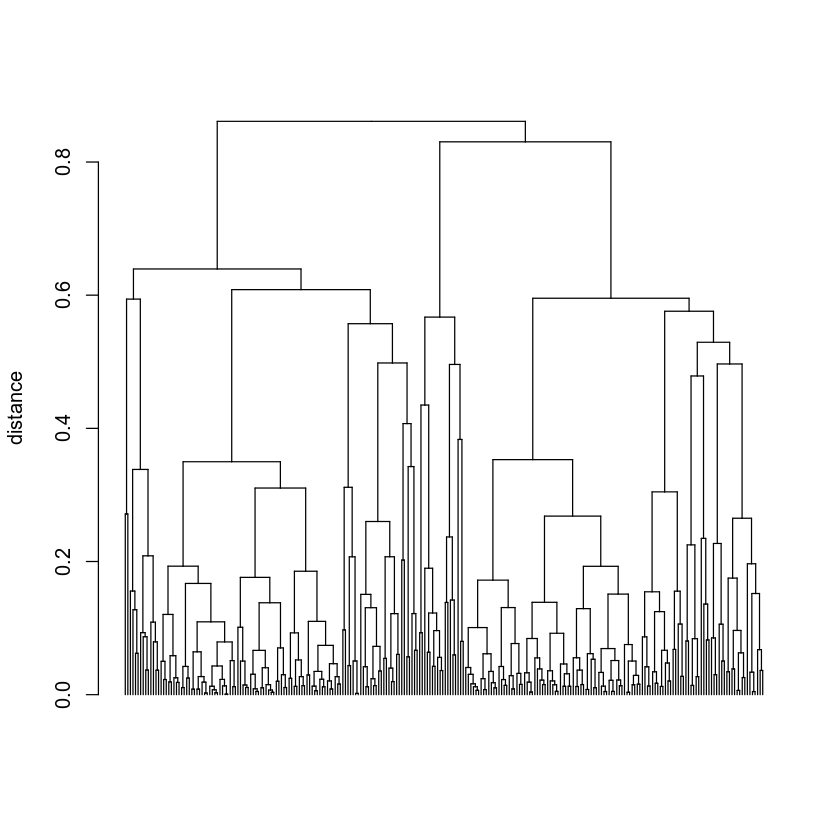

In [35]:
set.seed(301)
df <- loan_data[sample(nrow(loan_data), 250),
                c('dti', 'payment_inc_ratio', 'home_', 'purpose_')] %>%
  mutate(home_=as.factor(home_), purpose_=as.factor(purpose_))
d = daisy(df, metric='gower')
hcl <- hclust(d)
dnd <- as.dendrogram(hcl)
plot(dnd, leaflab='none', ylab='distance')

In [36]:
dnd_cut <- cut(dnd, h=.5)
df[labels(dnd_cut$lower[[4]]),]

,dti,payment_inc_ratio,home_,purpose_
,<dbl>,<dbl>,<fct>,<fct>
17286,19.79,16.55380,MORTGAGE,other
21988,10.36,14.34780,MORTGAGE,other
24706,5.59,3.83713,MORTGAGE,other
26082,1.18,2.94380,MORTGAGE,other
9840,26.12,4.90231,MORTGAGE,other
37913,19.78,5.24341,MORTGAGE,other
31884,19.65,5.16189,MORTGAGE,other


## Problems with Clustering Mixed Data

In [37]:
df <- model.matrix(~ -1 + dti + payment_inc_ratio + home_ + pub_rec_zero, data=defaults)
df0 <- scale(df)
km0 <- kmeans(df0, centers=4, nstart=10)
centers0 <- scale(km0$centers, center=FALSE, scale=1/attr(df0, 'scaled:scale'))
round(scale(centers0, center=-attr(df0, 'scaled:center'), scale=FALSE), 2)

,dti,payment_inc_ratio,home_MORTGAGE,home_OWN,home_RENT,pub_rec_zero
1,16.99,9.11,0.00,0,1.00,1.00
2,17.20,9.27,0.00,1,0.00,0.92
3,17.46,8.42,1.00,0,0.00,1.00
4,16.50,8.06,0.52,0,0.48,0.00
